### Transfer Learning

Chúng ta sẽ tiến hành xâu dựng mô hình Unet với pretrained model là Resnet 50.

Mô hình cần xây dựng là mô hình segmentation tóc.

Xây dựng chương trình với Tensorflow 2.3

In [ ]:
! nvidia-smi

Thu Sep 17 23:46:19 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Tiến hành tải và giải dữ liệu

Tiến hành tải và giải dữ liệu
Link dữ liệu tại đây

Có hai loại dữ liệu có kích thước nhỏ và lớn

Code tải dữ liệu:

Nhỏ: ```wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-9eY2slA6ZmdBLLEExdxhLcavm0bPZua' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1-9eY2slA6ZmdBLLEExdxhLcavm0bPZua" -O dataset.zip && rm -rf /tmp/cookies.txt```

Lớn: ```wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1hGVJJ0MERaP1ouEc_vcfFg1nS9aHeYw3' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1hGVJJ0MERaP1ouEc_vcfFg1nS9aHeYw3" -O dataset-large.zip && rm -rf /tmp/cookies.txt```

In [ ]:
! wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1hGVJJ0MERaP1ouEc_vcfFg1nS9aHeYw3' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1hGVJJ0MERaP1ouEc_vcfFg1nS9aHeYw3" -O dataset-large.zip && rm -rf /tmp/cookies.txt

In [ ]:
! mkdir dataset
! mkdir trained_model

In [ ]:
! unzip /content/dataset-large.zip -d /content/dataset/

### Xây dựng chương trình

In [ ]:
import os 
import cv2
import json
import random
import numpy as np
from glob import glob
from os.path import join
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.metrics import Recall, Precision

### Load và Write json

In [ ]:

def load_json(json_file):
    with open(json_file, 'r') as file:
        return json.loads(file.read())


def write_json(json_file, arr):
    with open(json_file, 'w') as file:
        json.dump(arr, file, indent=4)

### Data Augmentation

In [ ]:
class ToTensor(object):

    def __call__(self, img, mask):
        """
        Convert Image to Tensorflow Tensor
        :param img:
        :param mask:
        :return: img, mask
        """
        img = tf.convert_to_tensor(img)
        mask = tf.convert_to_tensor(mask)
        return img, mask


class Normalize(object):
    def __init__(self, std, mean):
        super(Normalize, self).__init__()
        self.std = std
        self.mean = mean

    def __call__(self, img, mask):
        """
        Normalize image with mean and std of imagenet dataset
        :param img:
        :param mask
        :return: img, mask
        """
        img = img / 255.0
        mask = mask / 255.0
        img -= self.mean
        img /= self.std
        return img, mask


class RandomFlip(object):

    def __call__(self, img, mask):
        """
        Flip image and mask, the image will be flipped hôintal, vertical or both
        :param img:
        :param mask:
        :return: img, mask
        """
        if random.choice([0, 1]):
            print(1)
            axis = random.choice([-1, 0, 1])
            img = cv2.flip(img, axis)
            mask = cv2.flip(img, axis)

        return img, mask


class Resize(object):
    def __init__(self, dim):
        super(Resize, self).__init__()
        self.dim = dim

    def __call__(self, img, mask):
        """
        Resize image with shape(width, height)
        :param img:
        :param mask:
        :return: img, mask
        """
        img = cv2.resize(img, self.dim)
        mask = cv2.resize(mask, self.dim)
        return img, mask


class RandomRotate(object):
    def __call__(self, img, mask):
        """
        Rotate image with random degree
        :param img:
        :param mask:
        :return:
        """
        degree = random.uniform(0, 360)
        h, w = img.shape[:2]
        c = cv2.getRotationMatrix2D((w/2, h/2), degree, scale=1.0)

        img = cv2.warpAffine(img, c, img.shape[:2])
        mask = cv2.warpAffine(mask, c, img.shape[:2])

        return img, mask


class RandomCrop(object):
    def __init__(self, dim):
        super(RandomCrop, self).__init__()
        self.dim = dim

    def __call__(self, img, mask):
        """
        Crop image with fixed shape and random
        :param img:
        :param mask:
        :return: img, mask
        """
        h, w = img.shape[:2]
        y = random.randint(0, h - self.dim[1])
        x = random.randint(0, w - self.dim[0])

        img = img[y:y+self.dim[1], x:x + self.dim[0]]
        mask = mask[y:y + self.dim[1], x:x + self.dim[0]]

        return img, mask


class RandomGaussianBlur(object):

    def __call__(self, img, mask):
        '''
        Blur image using Gaussian with random radius
        :param img:
        :param mask:
        :return: img, mask
        '''
        if random.choice([0, 1]):
            radius = random.choice([1, 3, 5])
            img = cv2.GaussianBlur(img, (radius, radius), 0)

        return img, mask


class ChangeBrightness(object):

    def __call__(self, img, mask):
        """
        Change Brightness of image, image can be brighter, darker or not
        :param img:
        :param mask:
        :return: img, mask
        """
        if random.choice([0, 1]):
            lookUpTable = np.empty((1, 256), np.uint8)
            gamma = random.uniform(0.1, 3)
            for i in range(256):
                lookUpTable[0, i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)
            img = cv2.LUT(img, lookUpTable)

        return img, mask

### Data Generator 

Xây dựng chương trình loader cho dữ liệu

In [ ]:
class Dataset(Sequence):
    def __init__(self, imgs, phase='Training', batch_size=8):
        self.phase = phase
        self.batch_size = batch_size
        self.imgs = imgs


    def load_data(self, imgs_batch):
        imgs = list()
        masks = list()

        for img_name in imgs_batch:
            img_path = join(img_paths, self.phase, img_name)
            mask_path = join(mask_paths, self.phase, img_name.split('.')[0] + '.png')

            img = cv2.imread(img_path)
            mask = cv2.imread(mask_path)

            if self.phase == 'Training':
                img, mask = self.train_transform(img, mask)
            else:
                img, mask = self.val_transfrom(img, mask)

            imgs.append(img)
            masks.append(mask)

        imgs = tf.convert_to_tensor(imgs)
        masks = tf.convert_to_tensor(masks)

        return imgs, masks


    def train_transform(self, img, mask):
        img, mask = Resize(dim=(256, 256))(img, mask)
        img, mask = RandomRotate()(img, mask)
        img, mask = ChangeBrightness()(img, mask)
        img, mask = RandomGaussianBlur()(img, mask)
        img, mask = RandomCrop(dim=(224, 224))(img, mask)
        img, mask = Normalize(std=[0.229, 0.224, 0.225],
                              mean=[0.485, 0.456, 0.406])(img, mask)
        img, mask = ToTensor()(img, mask[:, :, 0])

        return img, mask


    def val_transfrom(self, img, mask):
        img, mask = Resize(dim=(256, 256))(img, mask)
        img, mask = RandomCrop(dim=(224, 224))(img, mask)
        img, mask = Normalize(std=[0.229, 0.224, 0.225],
                              mean=[0.485, 0.456, 0.406])(img, mask)
        img, mask = ToTensor()(img, mask[:, :, 0])

        return img, mask


    def __getitem__(self, index):

        stop = (index + 1)*self.batch_size

        if stop > len(self.imgs):
            stop = len(self.imgs)

        imgs_batch = self.imgs[index*self.batch_size:stop]
        imgs, masks = self.load_data(imgs_batch)

        return imgs, masks


    def __len__(self):
        return int(np.ceil(len(self.imgs) / self.batch_size))

### Mô hình 

Xây dựng kiến trúc cho mô hình hair segmentation.

Kiến trúc: Unet + Resnet 50

In [ ]:
def Unet():
    inputs = Input(shape=(224, 224, 3), name="input_image")
    backbone = ResNet50(input_tensor=inputs, weights='imagenet', include_top=False)
    input_layer = backbone.get_layer(name='input_image')
    layer0 = backbone.get_layer(name='conv1_relu')
    layer1 = backbone.get_layer(name='conv2_block1_out')
    layer2 = backbone.get_layer(name='conv3_block2_out')
    layer3 = backbone.get_layer(name='conv4_block3_out')
    out_layer = backbone.get_layer(name='conv5_block2_out')


    encoder_out = out_layer.output
    x = up_sample(layer3, encoder_out, 1024)
    x = up_sample(layer2, x, 512)
    x = up_sample(layer1, x, 256)
    x = up_sample(layer0, x, 64)
    x = up_sample(input_layer, x, 32)

    x = Conv2D(1, (1, 1), padding="same")(x)
    out = Activation("sigmoid")(x)
    model = Model(inputs, out)
    return model

def conv_block(filters, x):
    x = Conv2D(filters=filters,
               kernel_size=(3, 3),
               padding='same',
               activation='relu')(x)

    x = BatchNormalization()(x)

    x = Conv2D(filters=filters,
               kernel_size=(3, 3),
               padding='same',
               activation='relu')(x)
    out = BatchNormalization()(x)
    return out

def up_sample( layer, input, filters):
    x1 = layer.output
    x = UpSampling2D((2, 2))(input)
    x = Concatenate()([x, x1])

    out = conv_block(filters, x)

    return out

### Metrics

In [ ]:
smooth = 1e-15
def iou(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def iou_loss(y_true, y_pred):
    return 1.0 - iou(y_true, y_pred)

### Huấn luyện mô hình

In [ ]:
img_paths = 'dataset/Original'
mask_paths = 'dataset/MASKS'
model_path = 'trained_model/hair_segmentation.h5'
json_path = 'dataset/data.json'

In [ ]:
# Tham số huấn luyện mô hình 
batch_size = 32
lr = 1e-3
epochs = 12
momentum = 0.9
num_classes = 1

In [ ]:
# Load dữ liệu 
data = load_json(json_path)
test_loader = Dataset(data['test'], phase='Testing', batch_size=batch_size)
train_loader = Dataset(data['train'], phase='Training', batch_size=batch_size)

In [ ]:
# load model
model = Unet()

losses = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum)
metrics = [iou, Recall(), Precision()]

In [ ]:
# Lập lịch cho learning rate
def scheduler(epoch, lr):
  if epoch < 4:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

In [ ]:
# huấn luyện 
model.compile(optimizer=optimizer, loss=iou_loss, metrics=metrics)
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

model.fit_generator(train_loader,
                    steps_per_epoch=len(train_loader),
                    epochs=epochs,
                    callbacks=[callback],
                    validation_data=test_loader,
                    validation_steps=len(test_loader))

Epoch 1/12
733/733 [==============================] - 745s 1s/step - loss: 0.2880 - iou: 0.7121 - recall_1: 0.8904 - precision_1: 0.8026 - val_loss: 0.1818 - val_iou: 0.8182 - val_recall_1: 0.8920 - val_precision_1: 0.9219
Epoch 2/12
733/733 [==============================] - 741s 1s/step - loss: 0.1783 - iou: 0.8217 - recall_1: 0.9009 - precision_1: 0.9164 - val_loss: 0.1412 - val_iou: 0.8588 - val_recall_1: 0.9265 - val_precision_1: 0.9304
Epoch 3/12
733/733 [==============================] - 720s 983ms/step - loss: 0.1582 - iou: 0.8418 - recall_1: 0.9054 - precision_1: 0.9297 - val_loss: 0.1321 - val_iou: 0.8679 - val_recall_1: 0.9428 - val_precision_1: 0.9235
Epoch 4/12
733/733 [==============================] - 722s 985ms/step - loss: 0.1481 - iou: 0.8519 - recall_1: 0.9082 - precision_1: 0.9359 - val_loss: 0.1233 - val_iou: 0.8767 - val_recall_1: 0.9370 - val_precision_1: 0.9371
Epoch 5/12
733/733 [==============================] - 719s 981ms/step - loss: 0.1402 - iou: 0.8598 - r

In [ ]:
model.save(model_path)

### Download model 

In [ ]:
from google.colab import files
files.download(model_path) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Test mô hình 

In [ ]:
def preprocessing(img):
  img, mask = Resize(dim=(224, 224))(img, img)
  img, mask = Normalize(std=[0.229, 0.224, 0.225],
                        mean=[0.485, 0.456, 0.406])(img, mask)
  img, _ = ToTensor()(img, mask[:, :, 0])

  return img


In [ ]:
img = cv2.imread('/content/dataset/Original/Testing/Frame00583-org.jpg')
img1 = preprocessing(img)
img1 = tf.expand_dims(img1, axis=0)

In [ ]:
mask = model.predict(img1)

In [ ]:
mask_ = np.squeeze(mask)

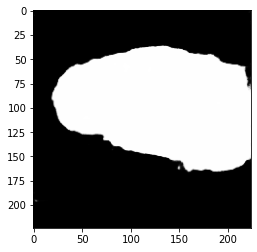

In [ ]:
plt.imshow(np.ndarray.astype(mask_*255, np.uint8), cmap='gray')

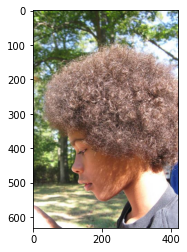

In [ ]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))